# Generalized linear mixed model

The specification of a linear mixed model includes a multivariate Gaussian distribution of the response, given the random effects 
$$
(\mathcal{Y}|\mathcal{B}=\bf{b})\sim\mathcal{N}(\bf{0},\sigma^2\bf{I}).
$$

However, it would not be appropriate to model a binary (i.e. Yes/No, true/false, etc.) response or counts that may be close to zero as having a Gaussian distribution.  We would typically use a Bernoulli or Poisson distribution in these cases.

*Generalized linear models* (GLMs) are used with such responses in the absence of random effects.  As with linear models, the product of an $n\times p$ *model matrix*, $\bf{X}$, and a $p$-dimensional coefficient vector, $\bf{\beta}$ creates the *linear predictor*, $\bf{\eta}=\bf{X\beta}$.  The response is modelled as independent values from a distribution such as Bernoulli or Poisson where the mean $\mu_i,i=1,\dots,n$ for the $i$th response is mapped to the linear predictor scale through an invertible *link function*, $g$.  That is, $$
\eta_i = g(\mu_i)\quad i = 1,\dots,n
$$
and
$$
\mu_i = g^{-1}(\eta_i)\quad i = 1,\dots,n .
$$

The vector-valued link and inverse link are written $\bf{g}$ and $\bf{g}^{-1}$, respectively.  Thus
$$
\bf{\mu} = \bf{g}^{-1}\left(\bf{X\beta}\right) .
$$

For distributions like Bernoulli or Poisson that depend only on their mean value, the model is completely specified by, say,
$$
\mathcal{Y}\sim\mathrm{Bernoulli}\left(\bf{g}^{-1}\left(\bf{X\beta}\right)\right).
$$

There is a remarkably fast algorithm, called *Iteratively Reweighted Least Squares* (IRLS), to determine the maximum likelihood estimates in a GLM.  It is especially effective when the *canonical link* for a distribution in the exponential family is used.  (See https://en.wikipedia.org/wiki/Generalized_linear_model for details.)

The canonical link function for the Bernoulli distribution is the *logit*, or log-odds function
$$
g(\mu) = \log\left(\frac{\mu}{1-\mu}\right)\quad 0 < \mu < 1
$$
and its inverse is the *logistic* function
$$
g^{-1}(\eta) = \frac{1}{1+\exp{-\eta}}\quad -\infty<\eta<\infty,
$$
which is the cumulative distribution function for the [*logistic distribution*](https://en.wikipedia.org/wiki/Logistic_distribution).

Fitting a Bernoulli GLM with a logit link is sometimes called [*logistic regression*](https://en.wikipedia.org/wiki/Logistic_regression).

The canonical link for the Poisson distribution is the *log link*,
$$
g(\mu) = \log(\mu)
$$
with inverse
$$
g^{-1}(\eta)=\exp(\eta).
$$

## Fitting a GLM

In [1]:
using DataFrames, DataFramesMeta, GLM, MixedModels, RData
using Gadfly: plot
using Gadfly.Geom: point, line, smooth
using Gadfly.Guide: xlabel, ylabel
const dat = convert(Dict{Symbol,Any},
    load(Pkg.dir("MixedModels", "test", "dat.rda")))

Dict{Symbol,Any} with 61 entries:
  :Assay         => 60×6 DataFrames.DataFrame…
  :WWheat        => 60×3 DataFrames.DataFrame…
  :Gasoline      => 32×6 DataFrames.DataFrame…
  :Alfalfa       => 72×4 DataFrames.DataFrame…
  :BIB           => 24×5 DataFrames.DataFrame…
  :IncBlk        => 24×8 DataFrames.DataFrame…
  :Semi2         => 72×6 DataFrames.DataFrame…
  :KWDYZ         => 28710×12 DataFrames.DataFrame…
  :Multilocation => 108×7 DataFrames.DataFrame…
  :Arabidopsis   => 625×8 DataFrames.DataFrame…
  :gb12          => 512×12 DataFrames.DataFrame…
  :Gcsemv        => 1905×5 DataFrames.DataFrame…
  :Hsb82         => 7185×8 DataFrames.DataFrame…
  :AvgDailyGain  => 32×6 DataFrames.DataFrame…
  :Dyestuff2     => 30×2 DataFrames.DataFrame…
  :InstEval      => 73421×7 DataFrames.DataFrame…
  :bdf           => 2287×28 DataFrames.DataFrame…
  :grouseticks   => 403×7 DataFrames.DataFrame…
  :Weights       => 399×4 DataFrames.DataFrame…
  :Mmmec         => 354×6 DataFrames.DataFrame…
  :Cu

The `Contraception` data are from a survey of women in Bangladesh that recorded, along with other covariates, whether or not the woman used artificial contraception.

In [2]:
dat[:Contraception]

,w,d,use,l,a,urb
1,1,1,N,3+,18.44,Y
2,2,1,N,0,-5.5599,Y
3,3,1,N,2,1.44,Y
4,4,1,N,3+,8.44,Y
5,5,1,N,0,-13.559,Y
6,6,1,N,0,-11.56,Y
7,7,1,N,3+,18.44,Y
8,8,1,N,3+,-3.5599,Y
9,9,1,N,1,-5.5599,Y
10,10,1,N,3+,1.44,Y


The `:a` column is the woman's centered, scaled age and `:use` is the indicator of artificial contraception use.  At present, this should be converted to a floating point vector for model fitting.

In [3]:
contra = @transform(dat[:Contraception], 
    Y = convert(Vector{Float64}, :use .== "Y"))

,w,d,use,l,a,urb,Y
1,1,1,N,3+,18.44,Y,0.0
2,2,1,N,0,-5.5599,Y,0.0
3,3,1,N,2,1.44,Y,0.0
4,4,1,N,3+,8.44,Y,0.0
5,5,1,N,0,-13.559,Y,0.0
6,6,1,N,0,-11.56,Y,0.0
7,7,1,N,3+,18.44,Y,0.0
8,8,1,N,3+,-3.5599,Y,0.0
9,9,1,N,1,-5.5599,Y,0.0
10,10,1,N,3+,1.44,Y,0.0


As always, it is a good idea to plot the data *before* fitting models. Because `:Y` is a 0/1 response there will be considerable overplotting of the response points and instead we plot the smoothed response.

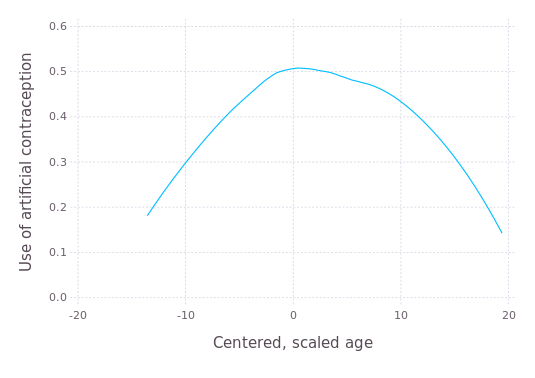

In [4]:
plot(contra, x = :a, y = :Y, smooth, xlabel("Centered, scaled age"),
    ylabel("Use of artificial contraception"))

Although the centering age was not available in the data source from which I obtained the data, my guess is that it is mid-to-late 20's, which makes the quadratic pattern understandable.  Very young women or middle-aged women are less likely to use artificial contraception than are women in their mid-to-late 20's.  The pattern continues to hold if we incorporate `:l`, the number of live children that the woman has.

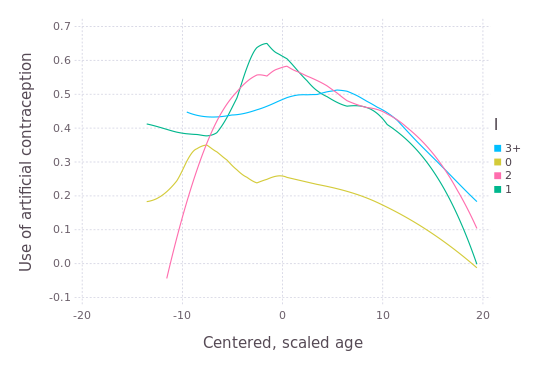

In [5]:
plot(contra, x = :a, y = :Y, color = :l, smooth,
    xlabel("Centered, scaled age"),
    ylabel("Use of artificial contraception"))

To create a quadratic in age, we must define a variable, `:a2`

In [7]:
contra = @transform(contra, a2 = abs2.(:a));
gm1 = glm(@formula(Y ~ 1 + a + a2 + urb + l), contra, Bernoulli())

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Bernoulli{Float64},GLM.LogitLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: Y ~ 1 + a + a2 + urb + l

Coefficients:
                Estimate   Std.Error  z value Pr(>|z|)
(Intercept)    -0.949952    0.155976 -6.09038    <1e-8
a             0.00458373  0.00890667  0.51464   0.6068
a2           -0.00428645 0.000699958 -6.12387    <1e-9
urb: Y          0.768097    0.106178  7.23408   <1e-12
l: 1            0.783112    0.156882  4.99174    <1e-6
l: 2            0.854904    0.178328  4.79399    <1e-5
l: 3+           0.806025    0.178448  4.51685    <1e-5
